In [1]:
import os
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_dir = "/home/simon/PycharmProjects/ObjectDetection/data/images"
files = os.listdir(image_dir)
images = [ski.io.imread(os.path.join(image_dir, file)) for file in files ]

In [50]:
from skimage.filters import threshold_otsu

from skimage.morphology import closing, square

from skimage.segmentation import clear_border

from skimage.color import rgb2gray, label2rgb

from skimage.measure import label, regionprops

import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

In [52]:
# Colors
green = (75/255., 244/255., 66/255.)
purple = [val / 255. for val in [160, 24, 137]]
grey = [val / 255. for val in [239, 239, 241]]
grey2purple = LinearSegmentedColormap.from_list("", [grey, purple])
white2purple = LinearSegmentedColormap.from_list("", ["white", purple])

In [60]:
# Bounding Box Offset
def offset(image, bbox, buffer=0.15):
    # Get coords
    minr, minc, maxr, maxc = bbox
    
    # Extend to have a buffer
    height = maxr - minr
    width = maxc - minc
    minr = max([1, minr-int(height*buffer)])
    maxr = min([image.shape[0]-1, maxr+int(height*buffer)])
    minc = max([1, minc-int(width*buffer)])
    maxc = min([image.shape[1]-1, maxc+int(width*buffer)])
    
    # Difference from original
    diff = [p2-p1 for p1,p2 in zip([minr, maxr, minr, maxc], bbox)] 
    
    # New bounding box
    bbox = [minr, minc, maxr, maxc]
    
    return bbox, diff

In [36]:
help(region)

Help on _RegionProperties in module skimage.measure._regionprops object:

class _RegionProperties(builtins.object)
 |  _RegionProperties(slice, label, label_image, intensity_image, cache_active, coordinates)
 |  
 |  Please refer to `skimage.measure.regionprops` for more information
 |  on the available region properties.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, slice, label, label_image, intensity_image, cache_active, coordinates)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  area
 |      Number of pixels of region.
 |  
 |  bbox
 |      Bounding box ``(min_row, m

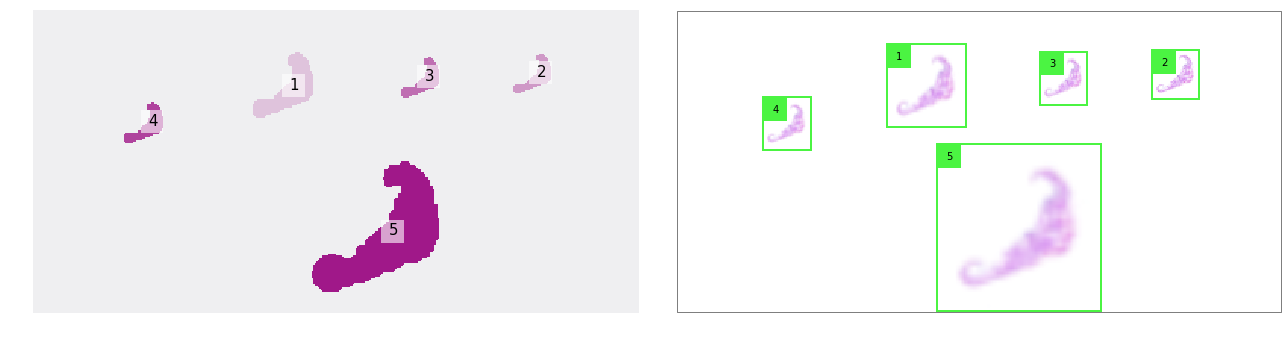

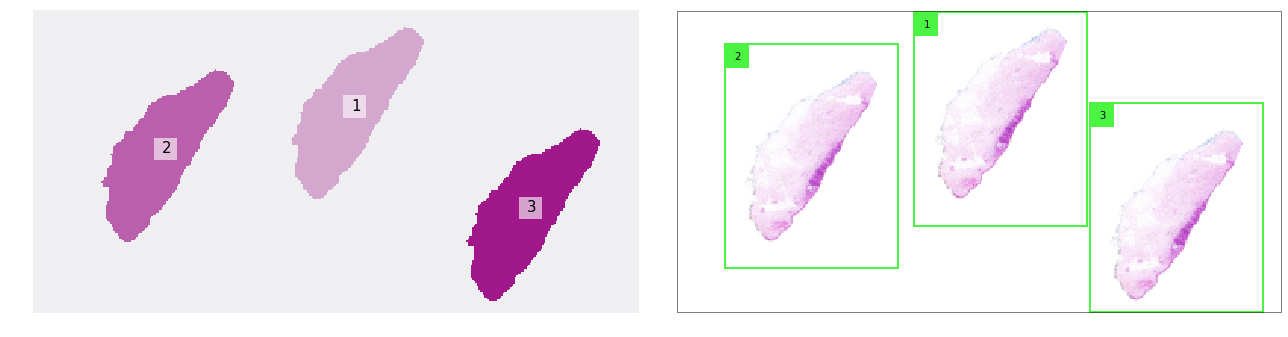

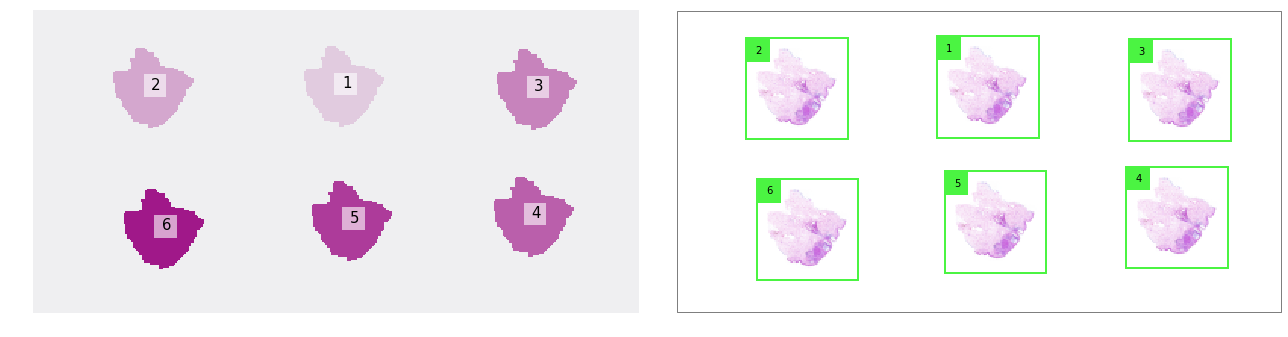

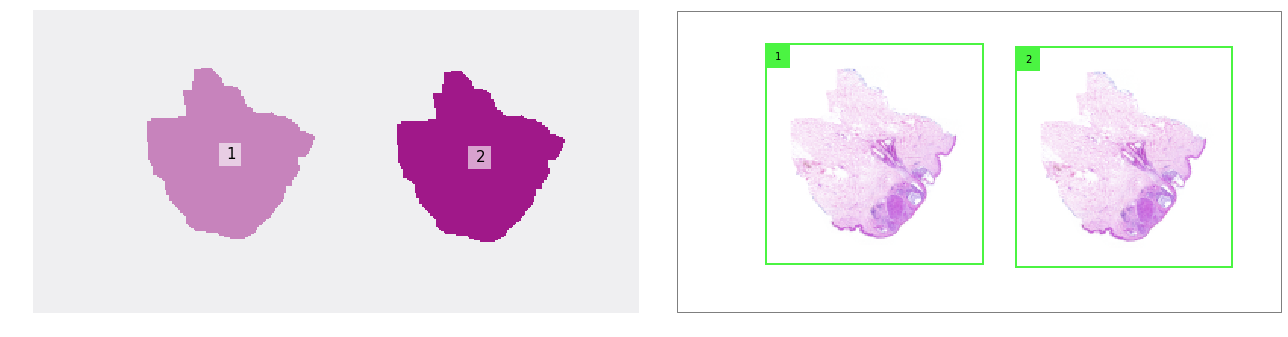

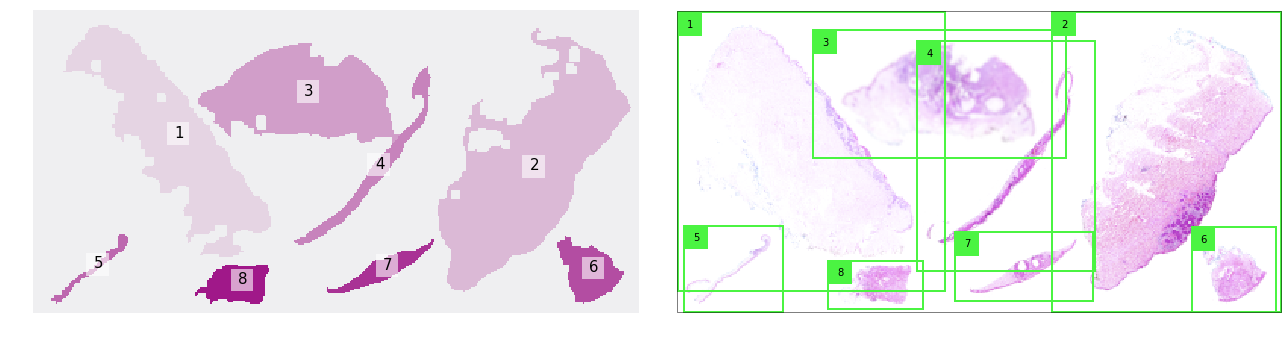

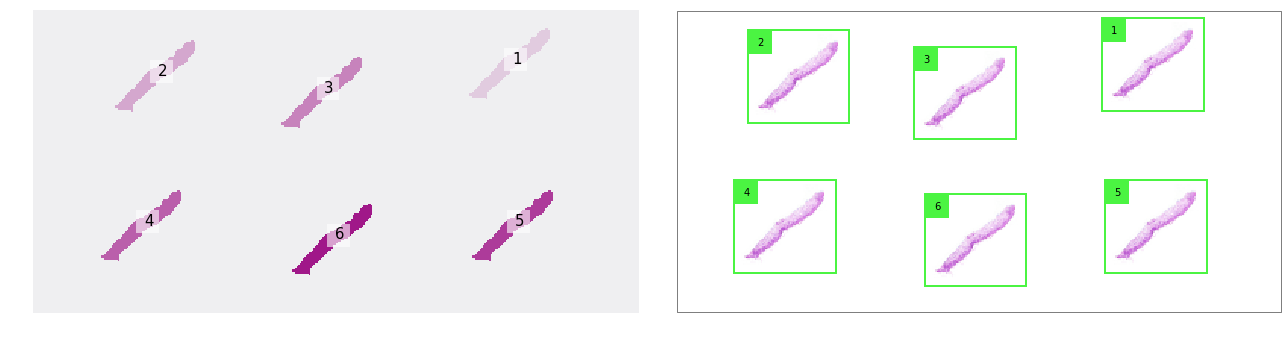

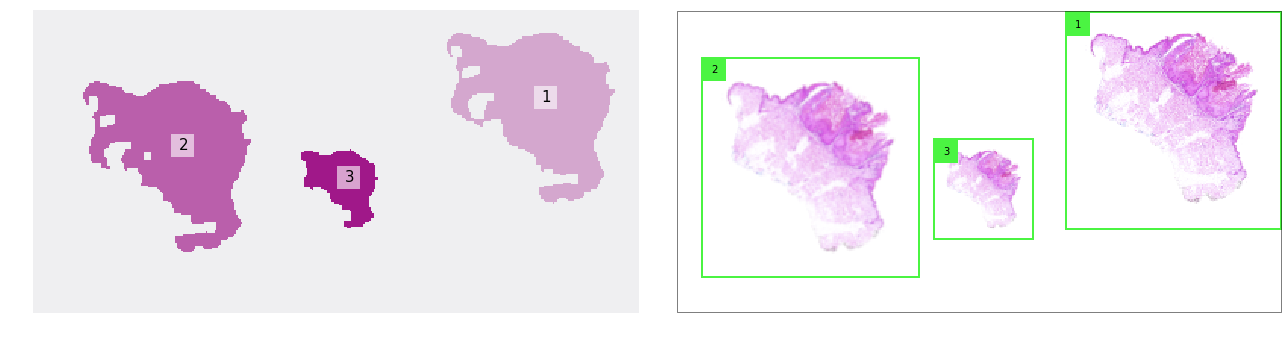

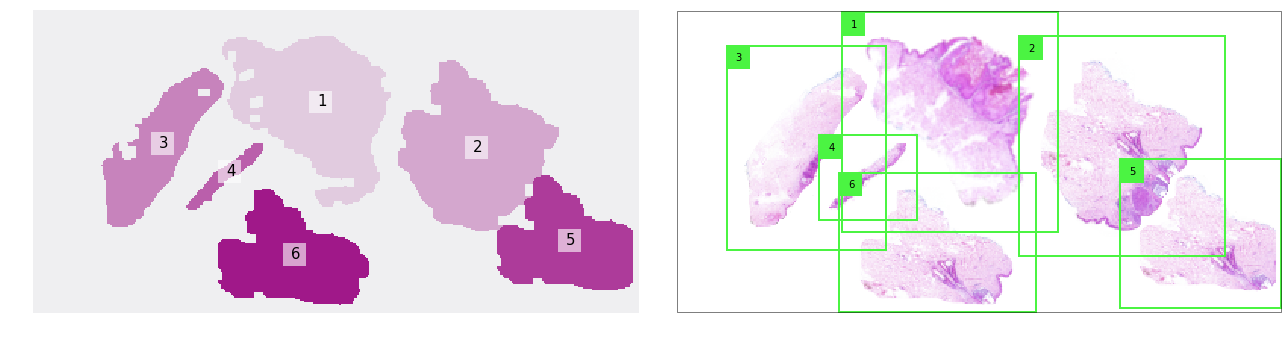

In [61]:
# Loop through images

image_bbox_pairs = {}

for i, image in enumerate(images):
    
    # Get a copy of image and convert to grayscale
    copy = image[:, :, 0:3].copy()
    grayscale = rgb2gray(copy)
    
    # Calculate and Apply Threshold 
    threshold = threshold_otsu(grayscale)
    bw = grayscale < threshold + threshold*0.1 # seems optimal
    # Close the image - fill bright regions
    bw_closed = closing(bw, square(2))
    
    # remove artifacts connected to image border
    cleared = clear_border(bw_closed)
    
    # label image regions
    label_image = label(cleared)
    
               
    # Plot mask and image
    fig, axes = plt.subplots(1, 2, figsize=(18, 12))
    axes[1].imshow(image)
    axes[1].axis("off")
    
    # Get region properties
    regions = regionprops(label_image)
    
    # Loop through proposals
    regions_to_keep = {}
    n = 1
    for region in regions:
        
        if region.area >= 200:
            
            # draw rectangle around segmented coins
            [minr, minc, maxr, maxc], _ = offset(image, region.bbox)
    
            # Create bounding box
            bbox = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor=green, linewidth=2)
            
            # Create label
            bbox_label = patches.Rectangle((minc, minr), 15, 15,
                                      fill=True, color=green, linewidth=2)
            
            # Text position
            text_x = minc + 6
            text_y = minr + 10
            
            # Add to plot
            axes[1].add_patch(bbox)
            axes[1].add_patch(bbox_label)
            axes[1].text(text_x, text_y, str(n))
            
            
            # Set label to n
            label_image[label_image == region.label] = n
        
            # Add text to mask 
            text_y, text_x = region.centroid
            
            text_box = patches.Rectangle((text_x-5, text_y-10), 15, 15,
                                      fill=True, color="white", linewidth=0, alpha=0.6)
            axes[0].add_patch(text_box)
            axes[0].text(text_x, text_y, str(n), size=15)
            
            # Save region
            regions_to_keep[n] = {"region" : region}
            n += 1
            
        else:
            # Set label to background
            label_image[label_image == region.label] = 0

    
    # Add border
    border = patches.Rectangle((0, 0), image.shape[1]-1, image.shape[0]-1,
                                      fill=False, edgecolor='black', linewidth=0.5)
    axes[1].add_patch(border)
    
    
    # Close label_image
    label_image = closing(label_image, square(5))
    
    # Add the mask
    image_label_overlay = label2rgb(label_image, image=bw)
    

    
    axes[0].imshow(label_image, vmin=0, vmax=n-1, cmap=grey2purple)
    axes[0].axis("off")
    
    
    plt.tight_layout()
    plt.show()
    
    regions_to_keep["label"] = label_image 
    
    # Save Image and Boundbox Data
    image_bbox_pairs[i] = regions_to_keep
    

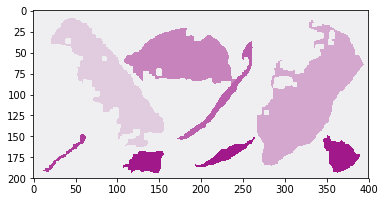

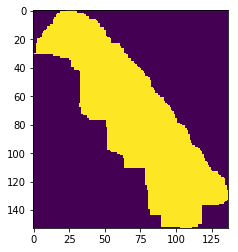

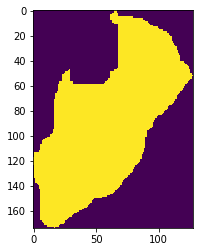

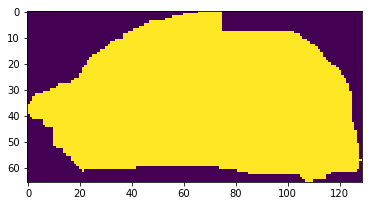

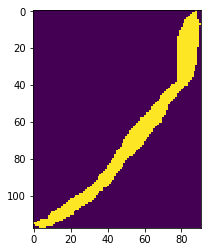

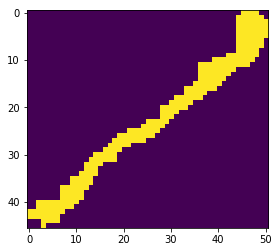

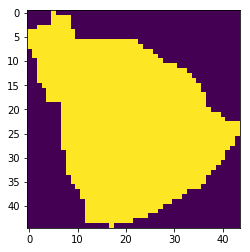

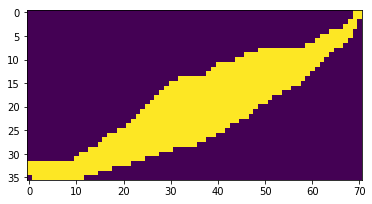

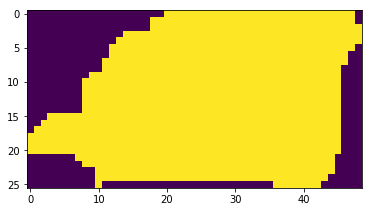

In [64]:
for i in range(4, 5):
    
    label_image = image_bbox_pairs[i]["label"]
    
    plt.imshow(label_image, vmin=0, vmax=n-1, cmap=grey2purple)
    plt.show()
    
    for n in [x for x in image_bbox_pairs[i]  if isinstance(x, int)]:
        
        region = image_bbox_pairs[i][n]["region"]
        
        mask = closing(region.image, square(20))
        
        plt.imshow(mask)
        plt.show()

In [53]:
help(regions)

Help on list object:

class list(object)
 |  list(iterable=(), /)
 |  
 |  Built-in mutable sequence.
 |  
 |  If no argument is given, the constructor creates a new empty list.
 |  The argument must be an iterable if specified.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |  
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate sign